# Quantum Random Walk on a line

A quantum random walk is the quantum extension of a classical random walk. Here we consider a walker that follows a random path through a graph. Quantum random walks offer some benefits to classical random walks, because they can make use of superposition and entanglement to explore all possible paths simultaneously. They are also important building blocks of more advanced quantum algorithms.

In this notebook we construct a Classiq program for a quantum walk on a line with 16 nodes.

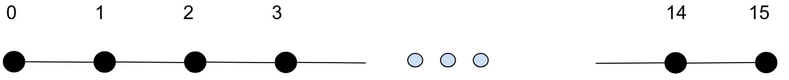
*Image credit: Womanium Quantum + AI 2024*

Each node is connected to its nearest neighbors. In each time step the random walker moves from its current node to an adjacent node. The probability of moving right or left are equal (1/2 each) and on the edge nodes the walker can only move in one direction (from node 0 to node 1 or from node 15 to node 14 with probability 1).

## Code

First we import the Classiq package and specify the size of our graph. Since we have 16 nodes, we need 4 qubits ($2^{4} = 16$). For a more general graph the size parameter has to be adjusted such that $2^{size} \geq nodes$.

In [1]:
from classiq import *

In [2]:
size = 4 # we have 16 nodes so we need 4 qubits since 2**4 = 16
nodes = 2**size # nodes stores the total number of nodes (16 in our case)

While the code below implements a quantum random walk on a line graph with 16 nodes, much of it is generic and small changes allow the code to be used on a graph with arbitrary structure and nodes. We will highlight the parts of the code that are specific to the line example and would need to be changed to consider a different graph structure (this is done via comments in the code cells). 

Generally quantum random walks consist of two steps applied repeatedly: 1. Walk and 2. Shift. During the "Walk" step, the walker's movement probabilities are determined and during the "Shift" step the walkers position is updated according to the probabilites determined in the "Walk step". Below we consider each step in detail.

### 1. Walk operator

The walk operator, $W$, determines the walker's movement probabilities. It transforms the walker's state by encoding movement probabilities to the next node into the amplitudes. The way this encoding is done depends on the graph structure. For our line graph, the walker can only move left or right (unless it is in an edge node). The graph structure is encoded in the prob list in the W_iteration function.  

In [8]:
@qfunc
def prepare_minus(x: QBit):
    """Helper function: prepares an input qubit in state |0> in state |->
    
    Args: x (QBit): the qubit to be prepared in state |->. In our case the auxillary qubit initialized in 
    the zero_diffuzer function.
    """
    X(x)
    H(x)

# The next two functions (diffuzer_oracle and zero_diffuzer) together apply a phase-kickback to the state encoding the adjacent_vertices. 
@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
    """This function applies the oracle for the phase-kickback.

    Args: aux (QNum): Auxillarry qubit for the phase-kickback
    x (QNum): Quantum number on which the oracle is applied (in our case adjacent_vertices)
    """
    aux^=(x!=0)


@qfunc
def zero_diffuzer(x: QNum):
    """This function applies a phase-kickback to the input QNum x based on the diffuzer_oracle function.

    Args: x (QNum): Quantum number on which to apply the phase-kickback
    """
    # Initialize auxillary qubit and transform it to |-> state, then apply oracle and transform auxillary qubit back to |0> state via within_apply.
    aux = QNum('aux')
    allocate(1,aux)
    within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)


def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    """This function is called in the W_operator function for each vertex (i) in our set of nodes.
    The list prob encodes the probabilities of the walker to transition to any other vertex given that it is currently at vertex i. This list is PROBLEM SPECIFIC and has to be adapted to the graph.
    For our line graph the probability to transition to the vertex left or right of the current vertex i is 1/2 each. At the edge nodes (i=0 and i=15), the walker deterministically transitions the the
    only adjacent vertex (i=1 and i=14 respectively). The probability vector for each state is printed to make it easier to check that the transition probabilites are encoded correctly.
    Then controlled on the vertex (whenever it is equal to i) the adjacent_vertices vector is prepared according to the probability list prob and the phase-kickback (zero-diffuzer) is applied to the
    adjacent_vertices state vector. Finally the state preparation is reversed (within_apply).

    Args: i (int): encodes the current vertex
    vertices (QNum): Quantum number encoding the vertices
    adjacent_vertices (QNum): Quantum number encoding the adjacent vertices
    """
    # Encode the transition probabilities between vertices in the graph. For a line graph 
    # the walker transitions left and right with equal probability (1/2) for every node except the edge nodes (i=0 and i=15)
    # This list, prob, is PROBLEM SPECIFIC!
    prob = [0]*nodes
    if i==0:
        prob[(i+1)]=1.0
    elif i==nodes-1:
        prob[(i-1)]=1.0
    else:
        prob[(i+1)]=0.5
        prob[(i-1)]=0.5
    print(f'State={i}, prob vec ={prob}')
    
    # Apply the zero_diffuzer to adjacent_vertices conditioned on the current vertex being i. Only in this case is prob the correct descirption of the transition probabilites to the adjacent vertices.
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


@qfunc 
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    """This function implements the complete walk operator. For each node in the graph the function W_iteration is called.

    Args: vertices (QNum): Quantum number encoding the vertices
    adjacent_vertices (QNum): Quantum number encoding the adjacent vertices
    """
    for i in range(nodes):
        W_iteration(i,vertices,adjacent_vertices)

### 2. Shift operator

In the second step the shift operator, $S$, is applied to the state of the walker. It realizes the walker's movement by performing a bitwise swap between adjacent vertices with the probabilities set by the $W$ operator. Since this operator acts on the state of the walker, which is in a superposition of different positions along the graph, multiple paths through the graph are considered simultaneously and quantum interfernce is leveraged to speed up the computation.

In [4]:
# For a line (and a larger circle) adjacent vertex has to be +/-1 of vertex, also works for edge nodes
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    """This function is an oracle that checks if two vertices are connected by an edge. The auxillary res qubit is set to state 1 whenever there is an edge between two vertices. It is 0 otherwise.
    To implement this logic an inplace OR operation is used. Whenver the vertices - adjacent_vertices = +/- 1 we set res to 1. The edge oracle is PROBLEM SPECIFIC it encodes the connection structure of the 
    line graph. Other graphs require a different oracle. 

    Args: res (QBit): Output qubit storing the result of the oracle query
    vertices (QNum): Quantum number encoding the vertices
    adjacent_vertices (QNum): Quantum number encoding the adjacent vertices
    """
    res |= (((vertices-adjacent_vertices) == -1) | ((vertices-adjacent_vertices) == 1))# inplace OR operation -> if statement is true, res=1 else 0
    

@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
    """Helper function that performs a bitwise swap between two qubit arrays of equal lengths.

    Args: x (QBit array): Input array of qubits
    y (QBit array): Input array of qubits
    """
    repeat(count=x.len, iteration= lambda i: SWAP(x[i],y[i]))
  

@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    """Applies the shift operator to swap vertices with their adjacent vertices. This moves the walker along the graph.

    Args: vertices (QNum): Quantum number encoding the vertices
    adjacent_vertices (QNum): Quantum number encoding the adjacent_vertices.
    """
    # Initialize the auxillary qubit for the edge oracle
    res = QNum('res')
    # call the edge oracle and store information about adjacent nodes in res qubit
    edge_oracle(res,vertices,adjacent_vertices)
    # Conditioned on there being an edge between two vertices (res==1), perform a bitwise swap (adjacent vertex becomes new position and old position (vertex) becomes an adjacent vertex)
    control(ctrl = res==1,
        operand = lambda: bitwise_swap(vertices,adjacent_vertices))

### 3. Quantum random walk on a line graph

To realize a quantum random walk on the line graph, we initialize the walker in an equal superposition of all possible nodes, $0, 1, ..., 15$. This is achieved via the hadamard_transform function. Then we apply the $W$ operator to this superposition state and finally we move the walker along the graph using the $S$ operator. This concludes the random walk. IN the end we create the quantum program for our random walk with qmod. 

In [5]:
@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):
    """This function performs a quantum random walk on a desired graph (the graph structure is encoded in the W and S operators).

    Args: vertices (QNum): Quantum numbers encoding the vertices in the graph
    adjacent_vertices (QNum): Quantum numbers encoding the adjacent vertices in the graph (need to move the walker)
    """
    # Intialize the vertices and adjacent_vertices states with the required number of qubits (size)
    allocate(size,vertices)
    allocate(size,adjacent_vertices)
    # Initialize the walker in an equal superposition of all possible nodes in the graph. 
    # This is done via the hadamard_transform (each basis state corresponds to one of the nodes)
    hadamard_transform(vertices)
    
    # Apply the W and S operators to the state of the walker to perform the random walk 
    W_operator(vertices,adjacent_vertices)
    S_operator(vertices,adjacent_vertices)

In [10]:
# Create the qmod model and synthesize the quantum program to perform the random walk on a line graph with 16 nodes
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0

The resulting quantum program is shown below:

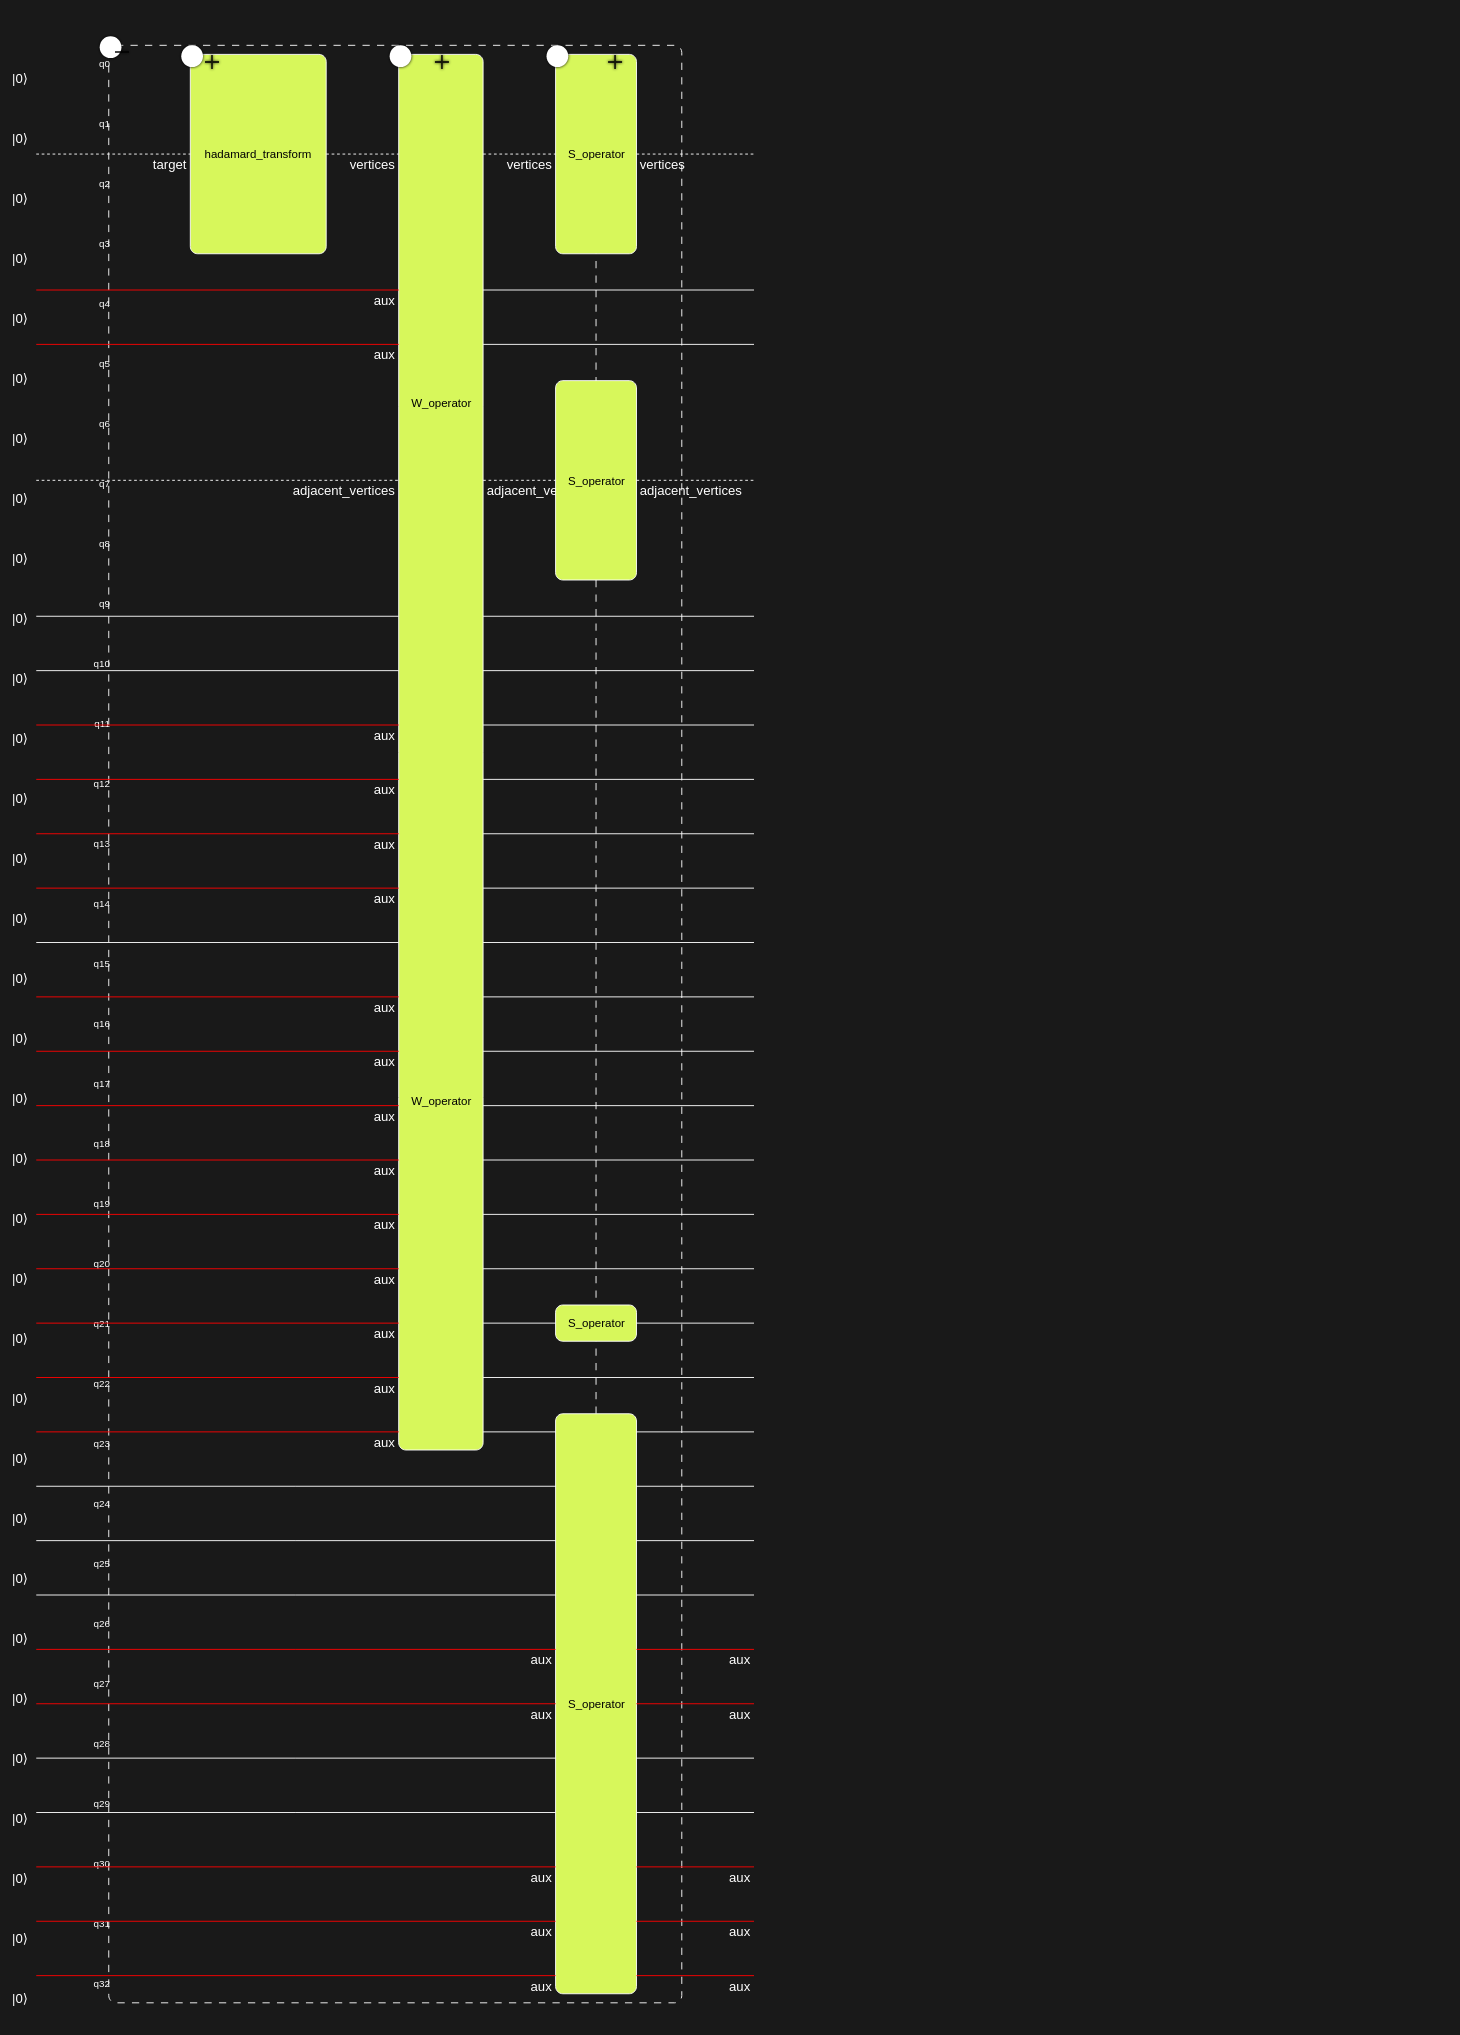

Note that the resulting program needs a lot more qubits than the 10 qubits (4 each for vertices and adjacent_vertices and two ancillary qubits, one for zero_diffuzer and one for edge_oracle). Looking at the structure we see that the desired algorithm for the random walk is implemented corectly. First a hadamard transform is applied to the 4 qubits representing the vertices, creating an equal superposition of starting positions for the walker, and then the $W$ and $S$ operators are applied one after the other. 

Now we can look at the way the two operators are implemented in more detail:

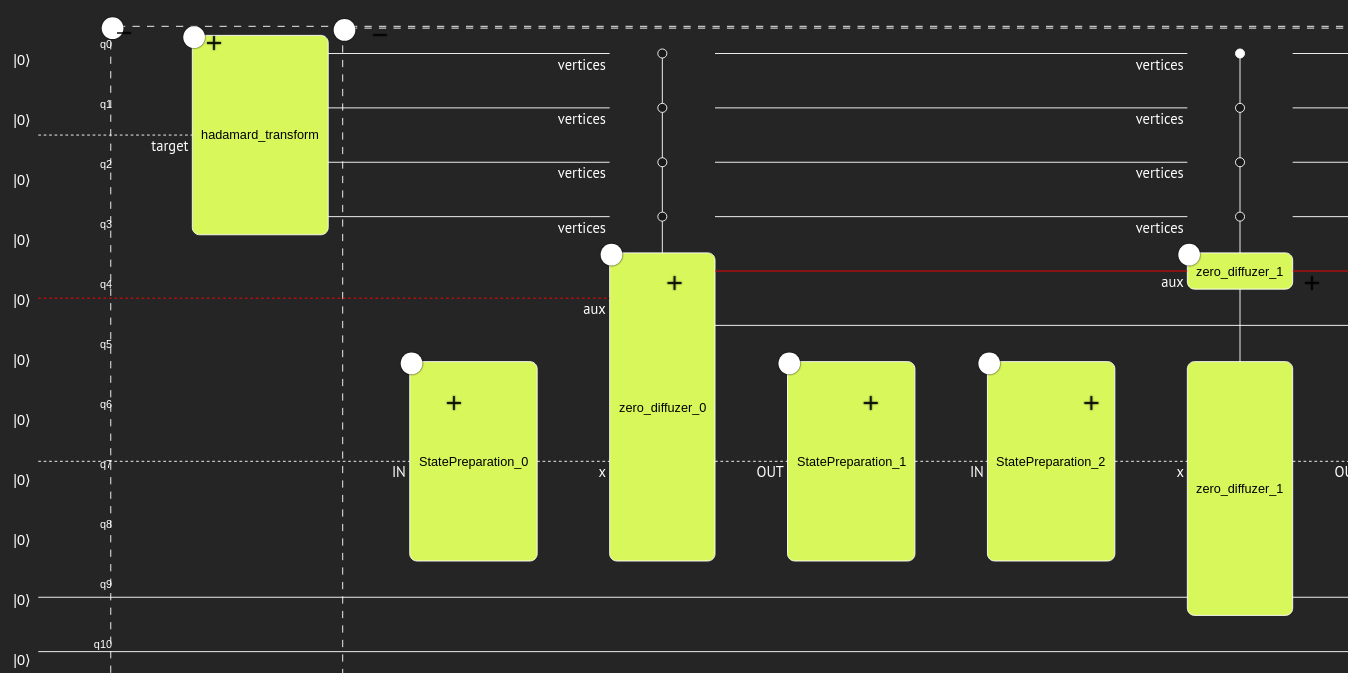

The full $W$ operator consists of many operations, therefore we only depcit a screenshot of the first couple of steps in its implementation. The first step is to prepare adjacent_vertices in the desired state (specified by the transition probabilities within the graph). This is taken care of in the StatePreparation block. Then the zero diffuzer is applied and the state preparation is reveresed. This block is repeated sequentially for all 16 vertices in the graph, but we only show the first couple of steps. All of this happens within the control function in the W_iteration script (the within_apply takes care of the state preparation and its reverse). 

The $S$ operator is easier to understand:

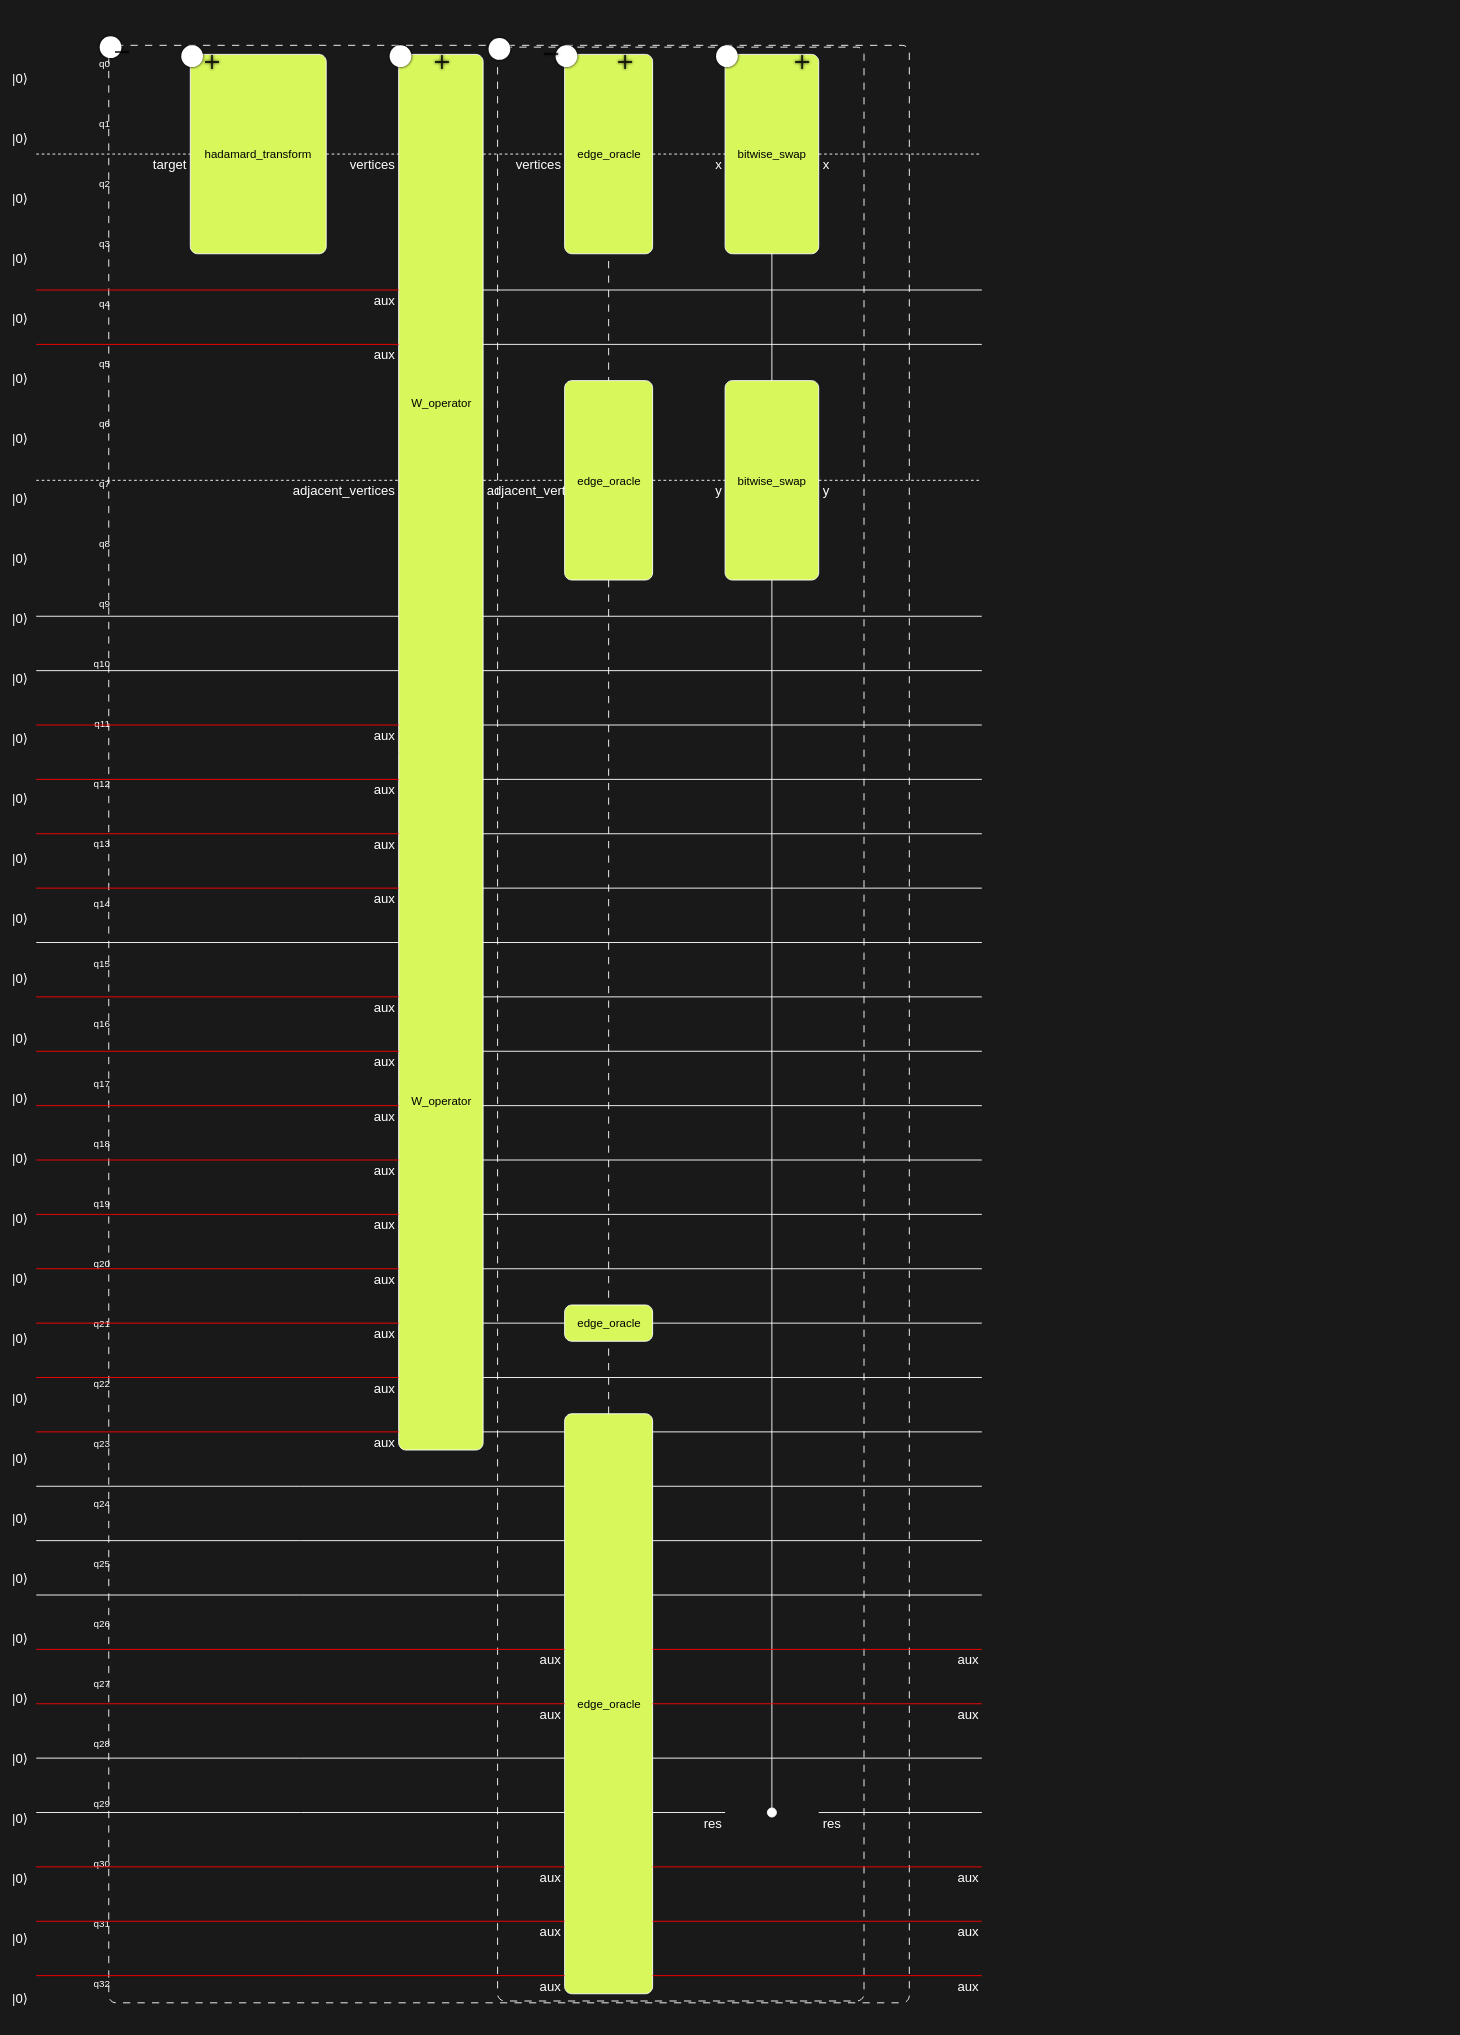

There are only two distinct blocks in the implementation of the Shift operator. First the edge oracle checks if vertices and adjacent vertices are connected by an edge. An auxillary qubit (res) stores the result of the oracle query and based on the state of this qubit a bitwise swap exchanges the states of the corresponding qubits in vertices and adjacent vertices. This swapping allows the walker to move through the graph and by conditioning it on the result of the edge oracle we ensure that the walker can only transition to adjacent nodes in every time step. 